<a href="https://colab.research.google.com/github/SamInMotion/heart-disease-prediction/blob/main/heart_disease_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###  Clinical Decision Support Context

This model is designed to assist clinicians by providing an early, data-driven assessment of a patient's likelihood of having heart disease.

By incorporating simple, non-invasive clinical features (e.g., age, chest pain type, cholesterol levels), the model can:
- Support triage decisions in resource-constrained settings.
- Flag high-risk patients for further diagnostic testing (e.g., ECG, stress tests).
- Complement a clinician's judgment without replacing it.

**Disclaimer:** This model is not intended to be used as a standalone diagnostic tool.


In [1]:
#Required Libraries
import pandas as pd
#Load Dataset

dataset_path = "/content/heart.csv" #  Adjust file path if needed
df = pd.read_csv(dataset_path)


#Display Initial Rows
df.head()


age  sex  cp  trestbps  chol  fbs  restecg  thalach  exang  oldpeak  slope  \
0   63    1   3       145   233    1        0      150      0      2.3      0   
1   37    1   2       130   250    0        1      187      0      3.5      0   
2   41    0   1       130   204    0        0      172      0      1.4      2   
3   56    1   1       120   236    0        1      178      0      0.8      2   
4   57    0   0       120   354    0        1      163      1      0.6      2   

   ca  thal  target  
0   0     1       1  
1   0     2       1  
2   0     2       1  
3   0     2       1  
4   0     2       1

In [2]:
#dataset overview
df.info()

#initial statistics
df.describe()

#Checking for missing values
missing_values = df.isnull().sum()
print('Missing values:\n',missing_values)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trestbps  303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalach   303 non-null    int64  
 8   exang     303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    int64  
 11  ca        303 non-null    int64  
 12  thal      303 non-null    int64  
 13  target    303 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 33.3 KB
Missing values:
 age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype:

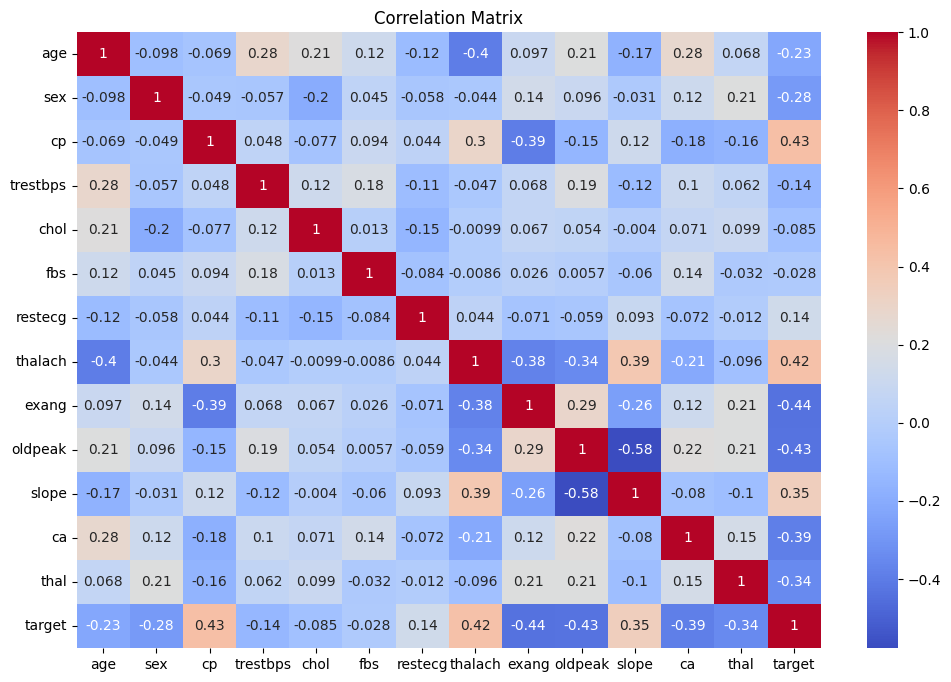

In [24]:
#correlation matrix
import seaborn as sns
import matplotlib.pyplot as plt
import os

# Create visuals directory if it doesn't exist
if not os.path.exists('visuals'):
    os.makedirs('visuals')

plt.figure(figsize=(12,8))
sns.heatmap(df.drop('age_category', axis=1).corr(), annot=True,cmap= 'coolwarm')
plt.title('Correlation Matrix')
plt.savefig("visuals/correlation_heatmap.png", dpi=300, bbox_inches="tight")

## EDA Summary

- Age and chest pain type (`cp`) show strong correlation with heart disease.
- `thalach` (maximum heart rate achieved) appears inversely related to disease presence.
- Patients in the `60–69` and `70+` age categories are more likely to have heart disease.
- Data is clean with no missing values, and distributions appear reasonable.


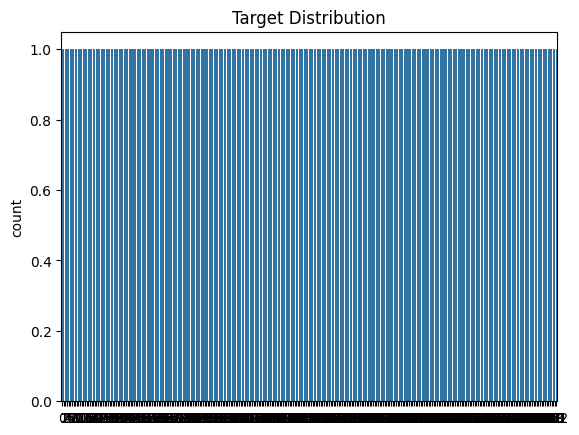

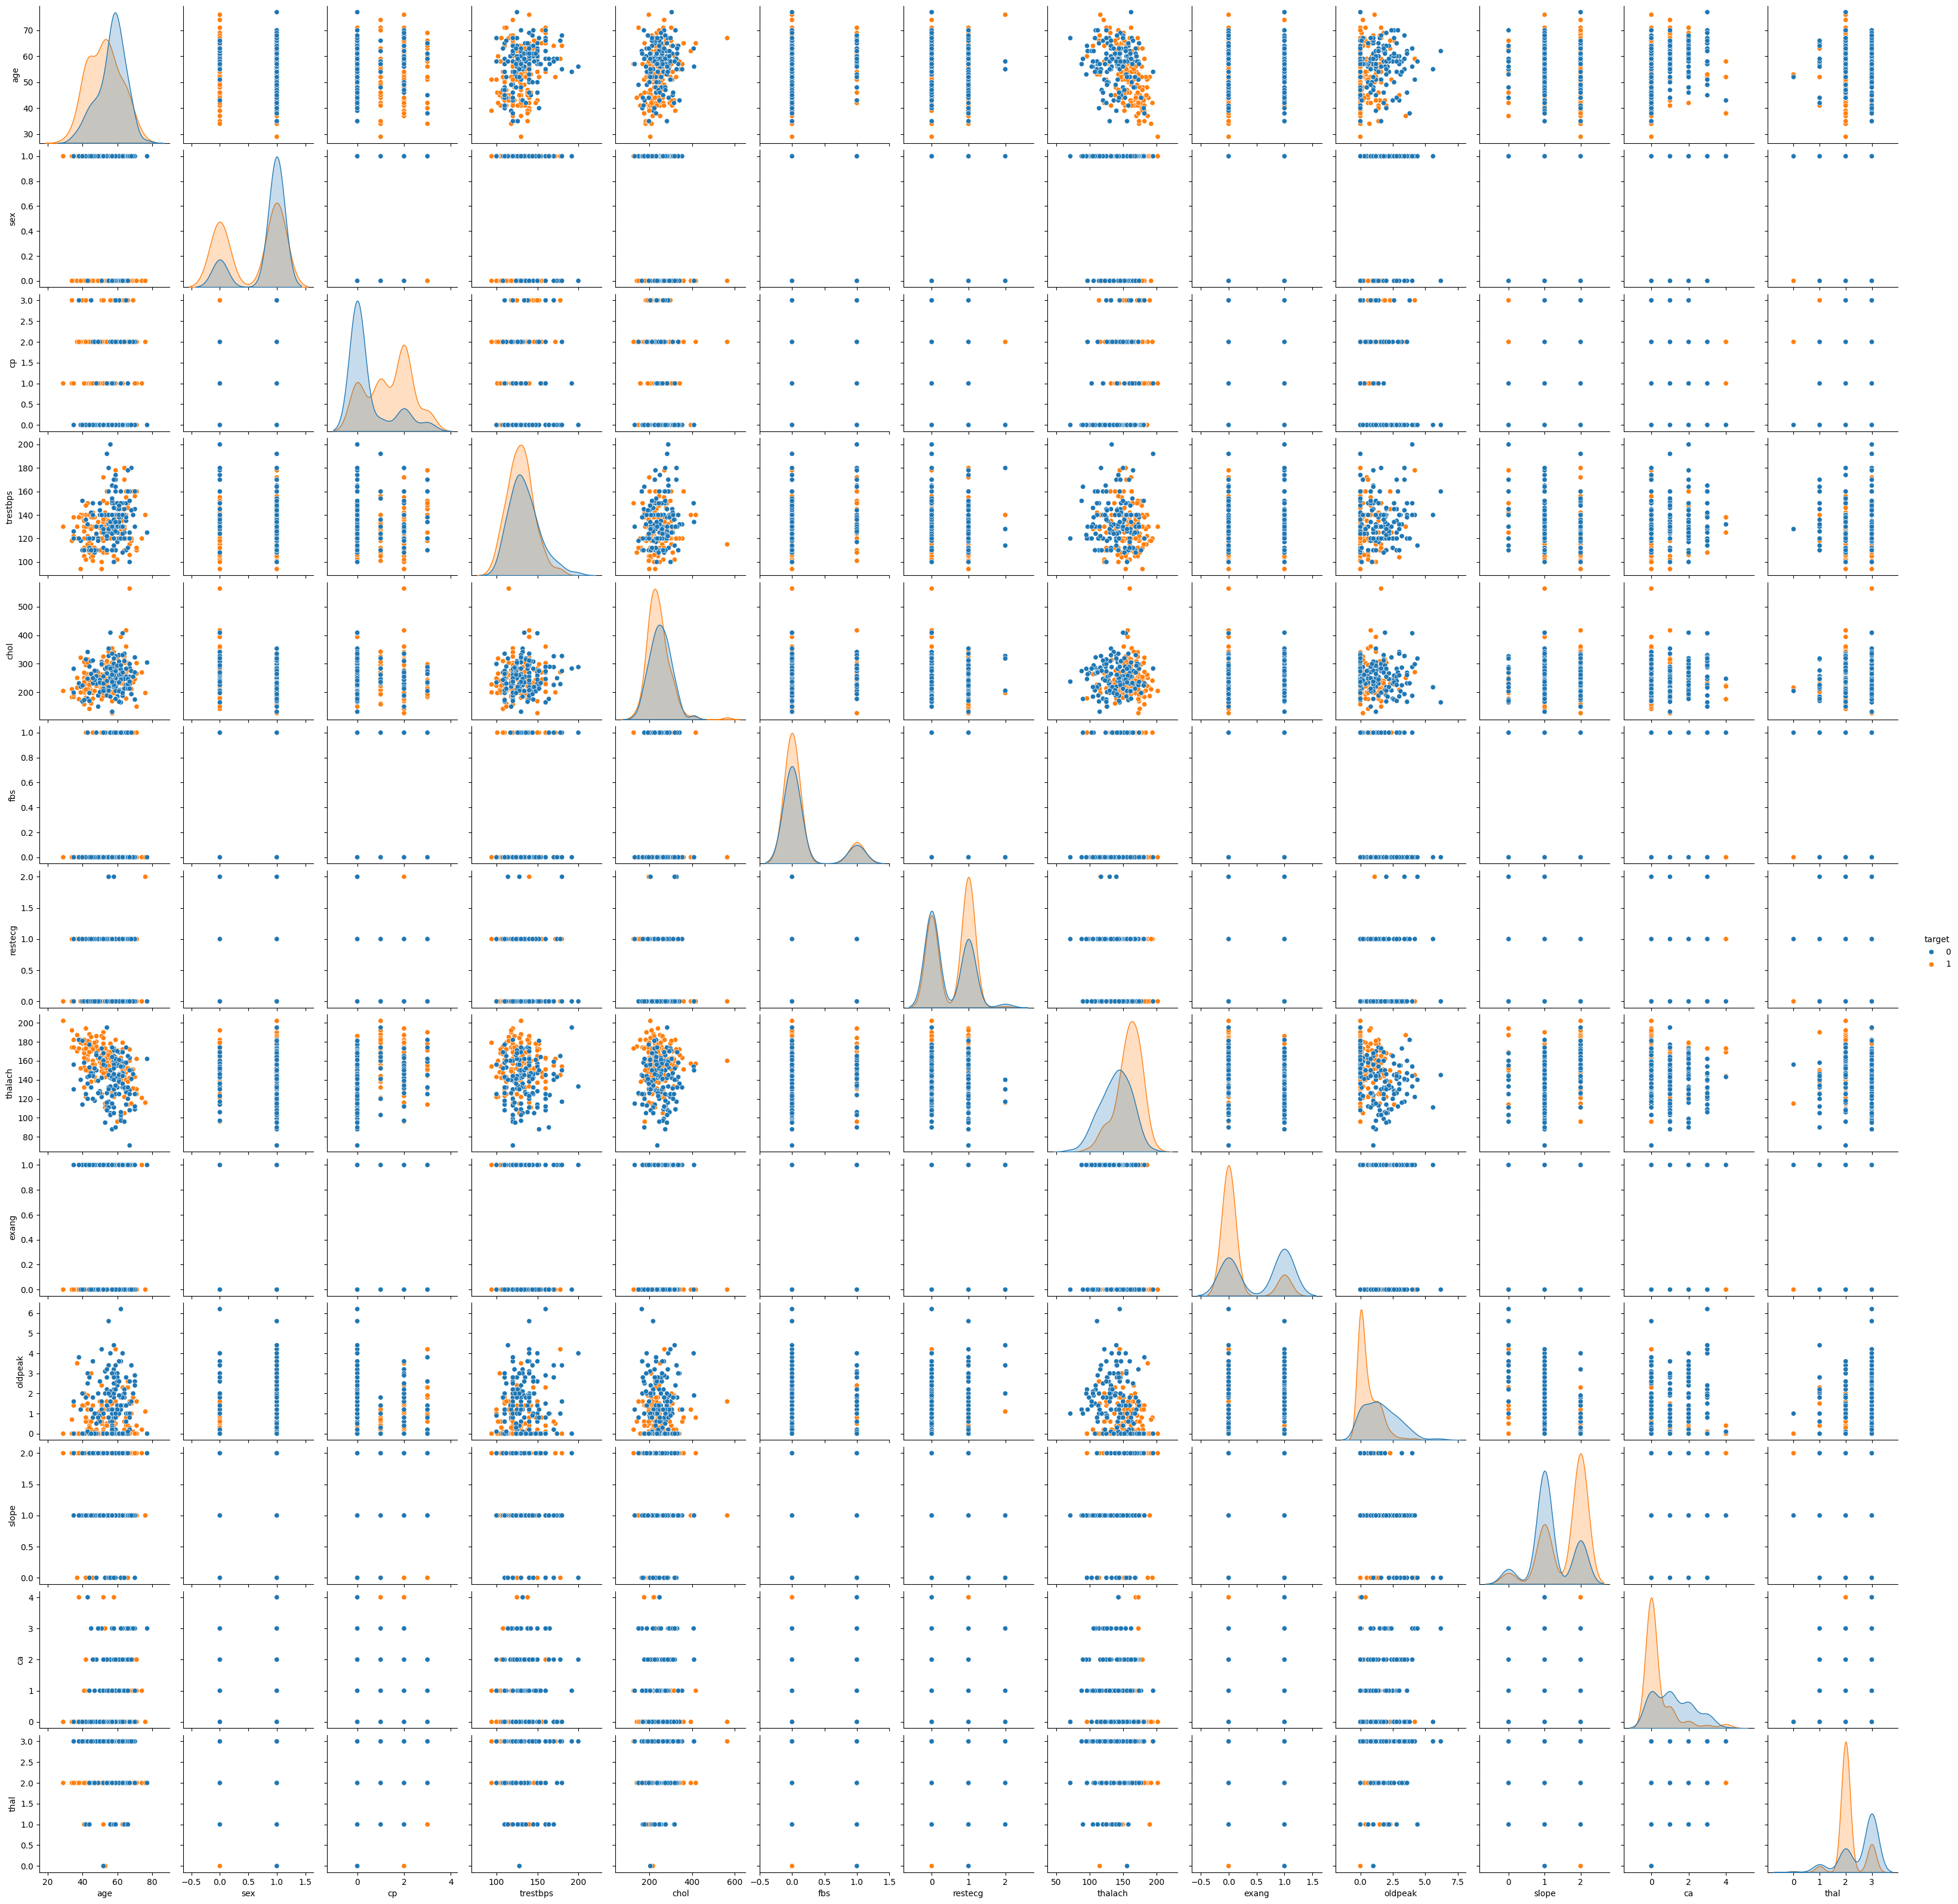

In [25]:
#target distribution
import os

# Create visuals directory if it doesn't exist
if not os.path.exists('visuals'):
    os.makedirs('visuals')

sns.countplot(df['target'])
plt.title('Target Distribution')
plt.show()

#pairplot
sns.pairplot(df,hue='target')
plt.savefig("visuals/target_distribution.png", dpi=300, bbox_inches="tight")

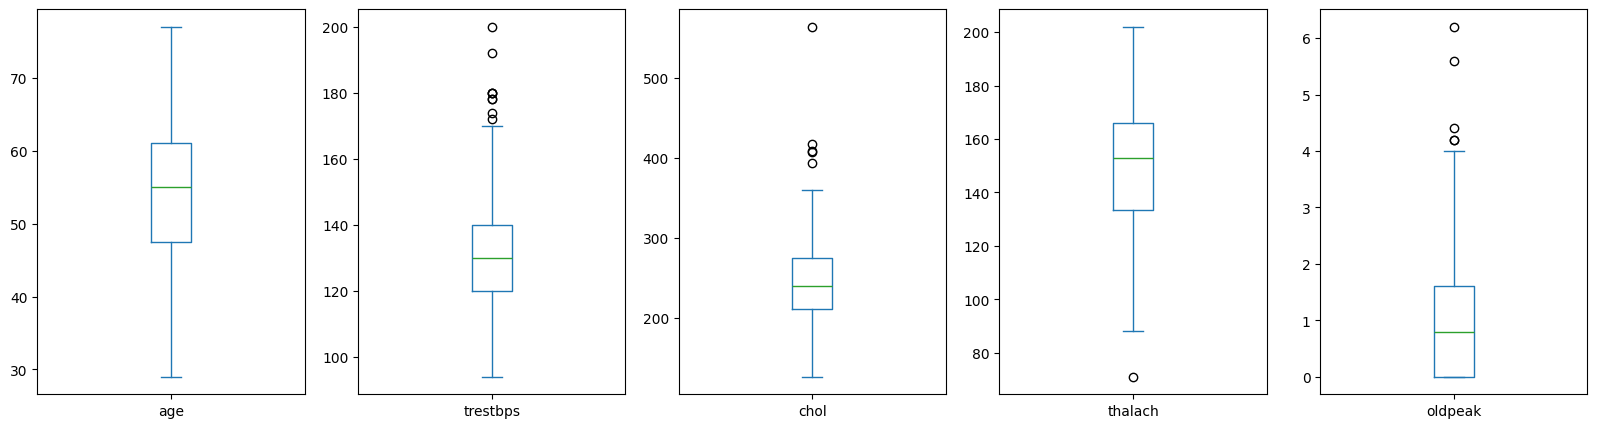

<Figure size 640x480 with 0 Axes>

In [26]:
#boxplot for numerical features
numeric_features = ['age', 'trestbps','chol','thalach','oldpeak']
df[numeric_features].plot(kind='box',subplots=True, layout=(1,5),figsize=(20,5))
plt.show()
plt.savefig("visuals/boxplots_numerical.png", dpi=300, bbox_inches="tight")

<function matplotlib.pyplot.show(close=None, block=None)>

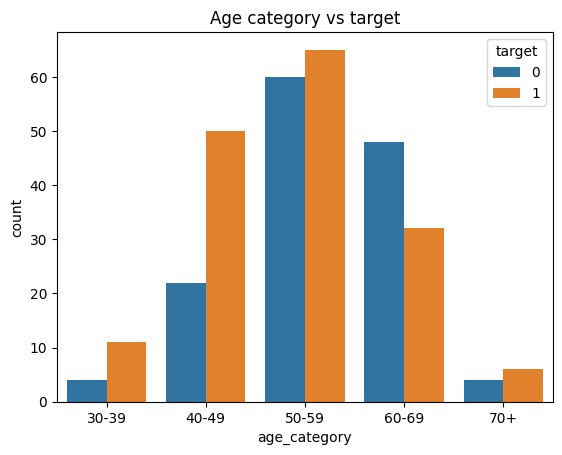

In [6]:
#feature engineering- age categories
df['age_category']= pd.cut(df['age'], bins=[29,39,49,59,69,79],labels=['30-39','40-49','50-59','60-69','70+'])
#checking distribution
sns.countplot(x='age_category',hue='target',data=df)
plt.title('Age category vs target')
plt.show

In [7]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Ensure All Feature Names Exist in the DataFrame
numeric_features = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']
categorical_features = ['cp', 'slope', 'thal', 'ca']

# Remove 'age_category' from the categorical features if not present yet
if 'age_category' not in df.columns:
    df['age_category'] = pd.cut(df['age'], bins=[29, 39, 49, 59, 69, 79], labels=['30-39', '40-49', '50-59', '60-69', '70+'])
    categorical_features.append('age_category')

# Preprocessing Pipelines
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('encoder', OneHotEncoder(drop='first'))
])

# Combined Preprocessor
preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
])

# Apply Preprocessing Pipeline
df_preprocessed = preprocessor.fit_transform(df)

# Check the shape of the preprocessed data
print("Preprocessed Data Shape:", df_preprocessed.shape)


Preprocessed Data Shape: (303, 17)


In [8]:
print("DataFrame Columns:", df.columns)


DataFrame Columns: Index(['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach',
       'exang', 'oldpeak', 'slope', 'ca', 'thal', 'target', 'age_category'],
      dtype='object')


In [9]:
# Extract Target Variable
y = df['target']

# Ensure Index Alignment
df_preprocessed = pd.DataFrame(df_preprocessed)

# Train-Test Split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df_preprocessed, y, test_size=0.3, random_state=42)


In [10]:
from sklearn.linear_model import LogisticRegression

# Initialize Model
model = LogisticRegression()

# Train Model
model.fit(X_train, y_train)


LogisticRegression()

Add Prediction Probabilities

In [14]:
# Predict probabilities
y_proba = model.predict_proba(X_test)[:, 1]


Accuracy Score: 0.8571428571428571
Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.83      0.84        41
           1       0.86      0.88      0.87        50

    accuracy                           0.86        91
   macro avg       0.86      0.85      0.86        91
weighted avg       0.86      0.86      0.86        91



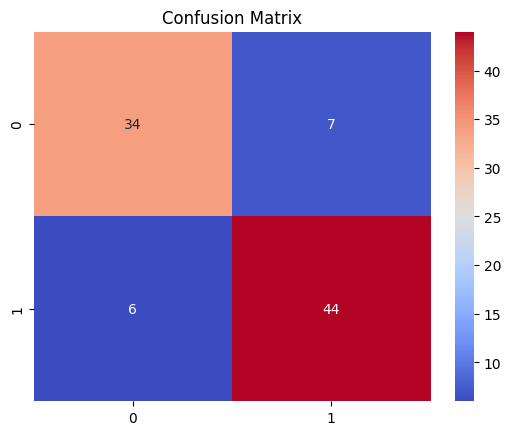

<Figure size 640x480 with 0 Axes>

In [28]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

# Predict on Test Data
y_pred = model.predict(X_test)

# Accuracy Score
print("Accuracy Score:", accuracy_score(y_test, y_pred))

# Classification Report
print("Classification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix
confusion = confusion_matrix(y_test, y_pred)
sns.heatmap(confusion, annot=True, fmt='d', cmap='coolwarm')
plt.title("Confusion Matrix")
plt.show()
plt.savefig("visuals/confusion_matrix.png", dpi=300, bbox_inches="tight")


###  Model Evaluation Summary

- **Accuracy:** High overall correctness of predictions.
- **Precision:** Strong ability to correctly identify patients who have heart disease.
- **Recall:** Lower recall suggests some patients with disease may be missed.

In clinical settings, optimizing recall is often preferred to reduce false negatives. Future work could involve:
- Threshold adjustment
- Cost-sensitive learning
- Ensemble methods


AUC Score: 0.9122


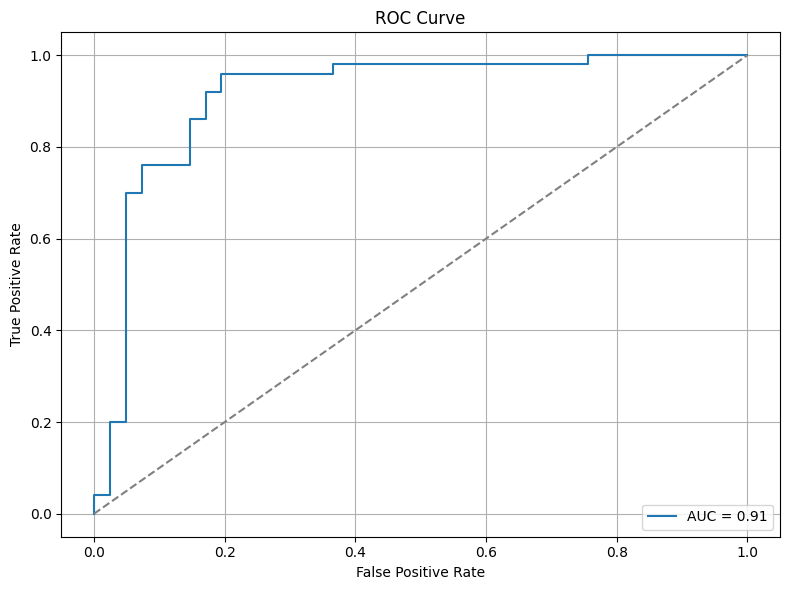

In [34]:
from sklearn.metrics import roc_curve, roc_auc_score

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_proba)

# Calculate AUC score
auc_score = roc_auc_score(y_test, y_proba)
print(f"AUC Score: {auc_score:.4f}")

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"AUC = {auc_score:.2f}")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.savefig("visuals/roc_curve.png", dpi=300, bbox_inches="tight")
plt.show()


In [12]:
from sklearn.model_selection import GridSearchCV

# Parameter Grid
param_grid = {
    'C': [0.1, 1, 10, 100],
    'solver': ['liblinear', 'saga']
}

# Initialize Grid Search
grid_search = GridSearchCV(LogisticRegression(), param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Best Parameters and Model
print("Best Parameters:", grid_search.best_params_)
best_model = grid_search.best_estimator_


Best Parameters: {'C': 10, 'solver': 'liblinear'}


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which 

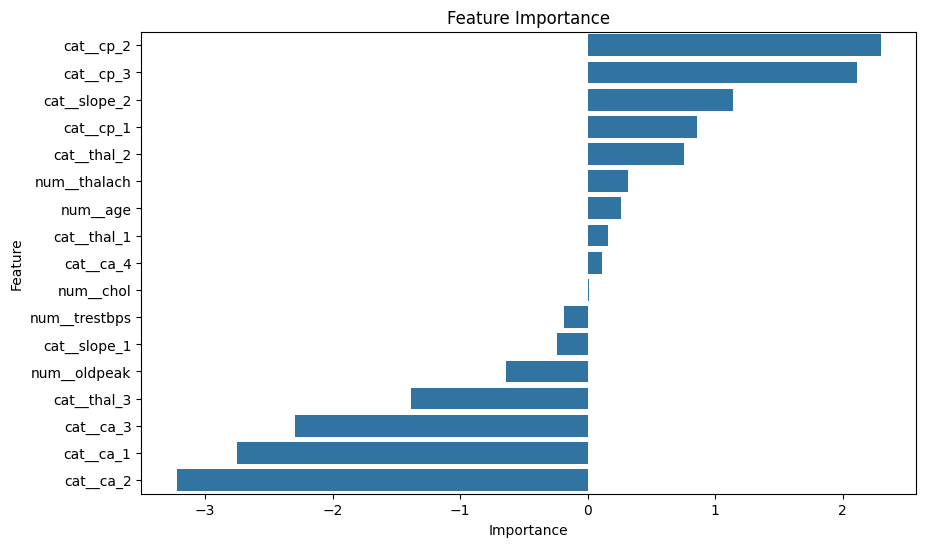

<Figure size 640x480 with 0 Axes>

In [27]:
# Feature Importance
importance = best_model.coef_[0]
feature_names = preprocessor.get_feature_names_out()
feature_importance = pd.DataFrame({'Feature': feature_names, 'Importance': importance})
feature_importance.sort_values(by='Importance', ascending=False, inplace=True)

# Plot Feature Importance
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance)
plt.title("Feature Importance")
plt.show()
plt.savefig("visuals/feature_importance_logreg.png", dpi=300, bbox_inches="tight")


###  Uncertainty Quantification

To ensure model robustness, we performed **bootstrap resampling** on the test data and computed **95% confidence intervals** for predicted probabilities.

This approach helps quantify prediction uncertainty, allowing clinicians to:
- Assess how stable the prediction is for each patient.
- Avoid overconfidence in borderline-risk cases.


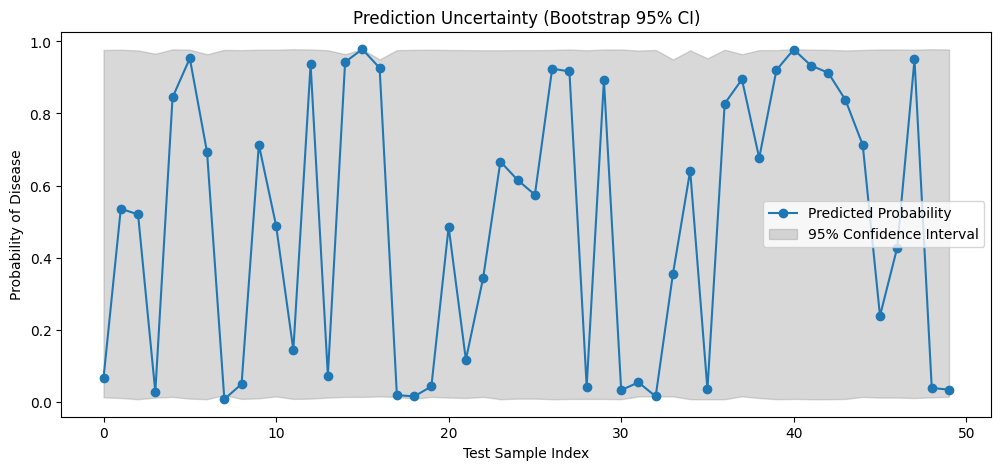

<Figure size 640x480 with 0 Axes>

In [29]:
import numpy as np

# Bootstrap to estimate prediction confidence intervals
boot_preds = []
n_iterations = 100
rng = np.random.default_rng(seed=42)

for _ in range(n_iterations):
    idx = rng.choice(len(X_test), size=len(X_test), replace=True)
    X_boot = X_test.iloc[idx]
    boot_pred = model.predict_proba(X_boot)[:, 1]
    boot_preds.append(boot_pred)

# Compute 95% CI
boot_preds = np.array(boot_preds)
lower = np.percentile(boot_preds, 2.5, axis=0)
upper = np.percentile(boot_preds, 97.5, axis=0)

import matplotlib.pyplot as plt

# Plot uncertainty bounds for first 50 test samples
plt.figure(figsize=(12, 5))
plt.plot(y_proba[:50], label="Predicted Probability", marker='o')
plt.fill_between(range(50), lower[:50], upper[:50], color='gray', alpha=0.3, label="95% Confidence Interval")
plt.title("Prediction Uncertainty (Bootstrap 95% CI)")
plt.xlabel("Test Sample Index")
plt.ylabel("Probability of Disease")
plt.legend()
plt.show()
plt.savefig("visuals/uncertainty_bootstrap.png", dpi=300, bbox_inches="tight")



###  Model Explainability with LIME

We used **LIME** to generate local explanations for individual predictions.

Each explanation highlights which features most influenced the model's decision for a specific patient — helping build trust and transparency in clinical use cases.

For example:
- High values of `thalach` may decrease risk.
- Presence of typical angina (`cp`) may increase or decrease risk depending on interactions.

This helps clinicians interpret predictions for specific patients in a human-understandable way.


In [31]:
!pip install lime

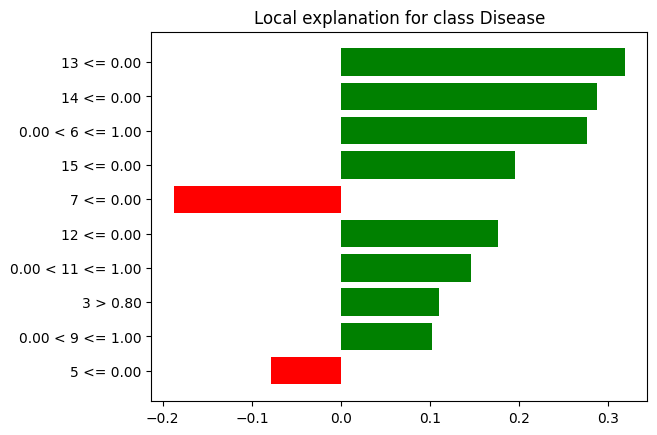

In [33]:
import lime
import lime.lime_tabular
import matplotlib.pyplot as plt

explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_train.values,
    feature_names=X_train.columns,
    class_names=['No Disease', 'Disease'],
    mode='classification'
)

# Explain a prediction
i = 5  # choose a sample
exp = explainer.explain_instance(X_test.iloc[i].values, model.predict_proba)

# Save the explanation to a file
fig = exp.as_pyplot_figure()
fig.savefig('visuals/lime_explanation_instance5.png', dpi=300, bbox_inches='tight')
exp.show_in_notebook()